# GC Stratify

Stratify early open peaks by GC content and see iPSC accessibility for each GC bucket, for clusters instead of days.

In [ ]:
library(ggplot2)
library(DESeq2)
library(dplyr)
library(patchwork)

In [ ]:
gz = gzfile("./data/cluster/clusters.20200125.n76770.overlap.200bp.counts.tsv.gz")
cts <- read.csv(gz,sep="\t")
rownames(cts)=paste(cts$chr,cts$start,cts$end,sep='\t')
cts$chrom = NULL
cts$start = NULL
cts$end = NULL
head(cts, 2)
dim(cts)

In [82]:
cts_gc <- read.csv("./data/cluster/clusters.20200125.n76770.overlap.200bp.gc.txt",sep="\t", header=F)
cts_gc$V1 = NULL # row order should be same as that of cts
rownames(cts_gc) = rownames(cts)
colnames(cts_gc) = "GC"
# cts_gc$GC_bucket = ntile(cts_gc$GC, 10)
cts_gc$GC_bucket = cut(cts_gc$GC, c(0,0.35,0.4,0.45,0.5,0.55,0.6,1))
head(cts_gc)

,GC,GC_bucket
,<dbl>,<fct>
chr1 16147 16347,0.525,"(0.5,0.55]"
chr1 180686 180886,0.505,"(0.5,0.55]"
chr1 181029 181229,0.705,"(0.6,1]"
chr1 181316 181516,0.735,"(0.6,1]"
chr1 184385 184585,0.575,"(0.55,0.6]"
chr1 191408 191608,0.630,"(0.6,1]"


In [83]:
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts))

In [84]:
log_norm_cts = log2(1+norm_cts)

In [85]:
quantile(log_norm_cts, c(0.1, 0.5, 0.9))

10%      50%      90% 
2.332292 4.821388 7.418387

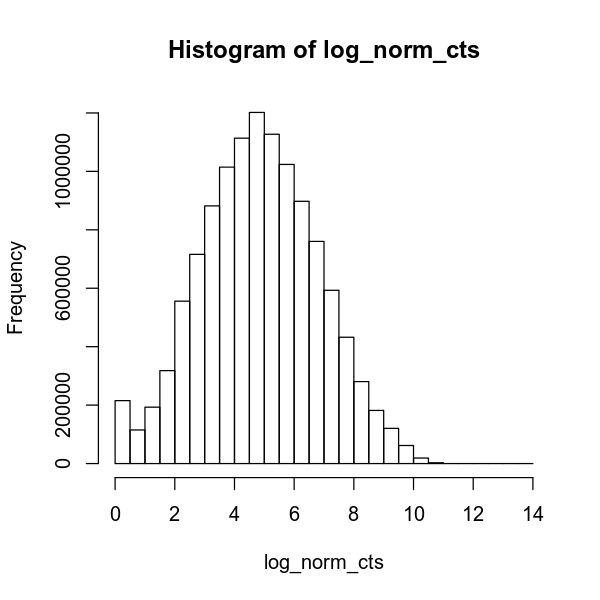

In [86]:
options(repr.plot.width = 5, repr.plot.height = 5)
hist(log_norm_cts)

## Remove promoter peaks

In [ ]:
library(EnsDb.Hsapiens.v86)

In [11]:
edb <- EnsDb.Hsapiens.v86

In [12]:
genes.hg38 = genes(edb, column = "gene_name", filter = GeneBiotypeFilter("protein_coding"))
seqlevels(genes.hg38) = paste("chr", seqlevels(genes.hg38), sep='')

In [13]:
prom.hg38 = promoters(genes.hg38, upstream = 5000, downstream = 1000)

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
"GRanges object contains 5 out-of-bound ranges located on sequences
  chrKI270721.1, chrKI270734.1, and chrMT. Note that ranges located on a
  sequence whose length is unknown (NA) or on a circular sequence are not
  considered out-of-bound (use seqlengths() and isCircular() to get the
  lengths and circularity flags of the underlying sequences). You can use
  trim() to trim these ranges. See ?`trim,GenomicRanges-method` for more
  information."


In [87]:
intervals_gr = GRanges(sub("\t", "-", sub("\t", ":", rownames(cts))))

In [88]:
overlaps = findOverlaps(prom.hg38, intervals_gr)
overlaps

Hits object with 92141 hits and 0 metadata columns:
          queryHits subjectHits
          <integer>   <integer>
      [1]         2           2
      [2]         2           3
      [3]         2           4
      [4]         6          62
      [5]         6          63
      ...       ...         ...
  [92137]     22261      656925
  [92138]     22261      656926
  [92139]     22262      656940
  [92140]     22262      656941
  [92141]     22262      656942
  -------
  queryLength: 22285 / subjectLength: 656958

In [89]:
dim(cts[-(unique(subjectHits(overlaps))),])

[1] 575766     18

In [90]:
norm_cts_no_prom = norm_cts[-(unique(subjectHits(overlaps))),]
log_norm_cts_no_prom = log_norm_cts[-(unique(subjectHits(overlaps))),]
cts_gc_no_prom = cts_gc[-(unique(subjectHits(overlaps))),]
# cts_gc_no_prom$GC_bucket = ntile(cts_gc_no_prom$GC, 10)

## Plotting

In [266]:
make_violin_plot <- function(gc_buckets, cts, title) {
    p <- ggplot(data.frame(x=as.factor(gc_buckets),
                      y=cts), 
           aes(x=x, y=y)) +
#         ylim(c(0,10)) +
        coord_cartesian(ylim=c(0,10)) +
        theme_classic() +
#         geom_violin(fill="black") + 
        stat_boxplot(geom = "errorbar", width = 0.2) +
        geom_boxplot() + 
        xlab("Peak GC Content") +
        ylab("Normalized Log2 Counts") + 
        ggtitle(title) +
        theme(
    #           plot.margin = margin(5,1,5,1, "cm"),
#               axis.text.x = element_text(angle = 0, hjust = 1),
              plot.title = element_text(hjust = 0.5, size=20),
              axis.ticks.x=element_blank(),
              legend.position = "none"
    );  
    p
}

In [181]:
peak_subset = (log_norm_cts_no_prom[,"cluster6"] < quantile(log_norm_cts_no_prom[,"cluster6"], .2)) # & (log_norm_cts_no_prom[,"cluster16"] > quantile(log_norm_cts_no_prom[,"cluster16"], 0.5))

In [182]:
sum(peak_subset)

[1] 109019

In [183]:
quantile(cts_gc_no_prom[peak_subset, "GC"],seq(0,1,.1))

0%   10%   20%   30%   40%   50%   60%   70%   80%   90%  100% 
0.100 0.320 0.350 0.370 0.395 0.420 0.445 0.475 0.510 0.560 0.845

In [184]:
100*table(cts_gc_no_prom[peak_subset,]$GC_bucket)/sum(peak_subset)


  (0,0.35] (0.35,0.4] (0.4,0.45] (0.45,0.5] (0.5,0.55] (0.55,0.6]    (0.6,1] 
 21.697135  21.221989  19.633275  16.122878  10.189967   6.392464   4.742293 

In [281]:
gc_bucket = ntile(cts_gc_no_prom[peak_subset, "GC"],10)

bucket_quantiles = quantile(cts_gc_no_prom[peak_subset, "GC"], seq(0,1,0.1))
bucket_labels = c()
for (i in seq(1,length(bucket_quantiles)-1)) {
    bucket_labels = c(bucket_labels, paste(bucket_quantiles[i], bucket_quantiles[i+1], sep='-'))
}
gc_bucket = factor(bucket_labels[gc_bucket], levels=bucket_labels)

# Just use original manual GC bucket
#gc_bucket = cts_gc_no_prom[peak_subset,]$GC_bucket

c6_violin = make_violin_plot(gc_bucket, log_norm_cts_no_prom[peak_subset,"cluster6"], "Fibroblast (Cluster 6)")
c1_violin = make_violin_plot(gc_bucket, log_norm_cts_no_prom[peak_subset,"cluster1"], "Fibroblast (Cluster 1)")
c7_violin = make_violin_plot(gc_bucket, log_norm_cts_no_prom[peak_subset,"cluster7"], "Neuroecto (Cluster 7)")
c8_violin = make_violin_plot(gc_bucket, log_norm_cts_no_prom[peak_subset,"cluster8"], "Keratinocytes (Cluster 8)")
c10_violin = make_violin_plot(gc_bucket, log_norm_cts_no_prom[peak_subset,"cluster10"], "Intermediate (Cluster 10)")
c9_violin = make_violin_plot(gc_bucket, log_norm_cts_no_prom[peak_subset,"cluster9"], "Intermediate (Cluster 9)")
c15_violin = make_violin_plot(gc_bucket, log_norm_cts_no_prom[peak_subset,"cluster15"], "cluster15")
c16_violin = make_violin_plot(gc_bucket, log_norm_cts_no_prom[peak_subset,"cluster16"], "cluster16")
c13_violin = make_violin_plot(gc_bucket, log_norm_cts_no_prom[peak_subset,"cluster13"], "cluster13")
c14_violin = make_violin_plot(gc_bucket, log_norm_cts_no_prom[peak_subset,"cluster14"], "Neuroecto (Cluster 14)")
c4_violin = make_violin_plot(gc_bucket, log_norm_cts_no_prom[peak_subset,"cluster4"], "D14 Pre-iPSC (Cluster 4)")

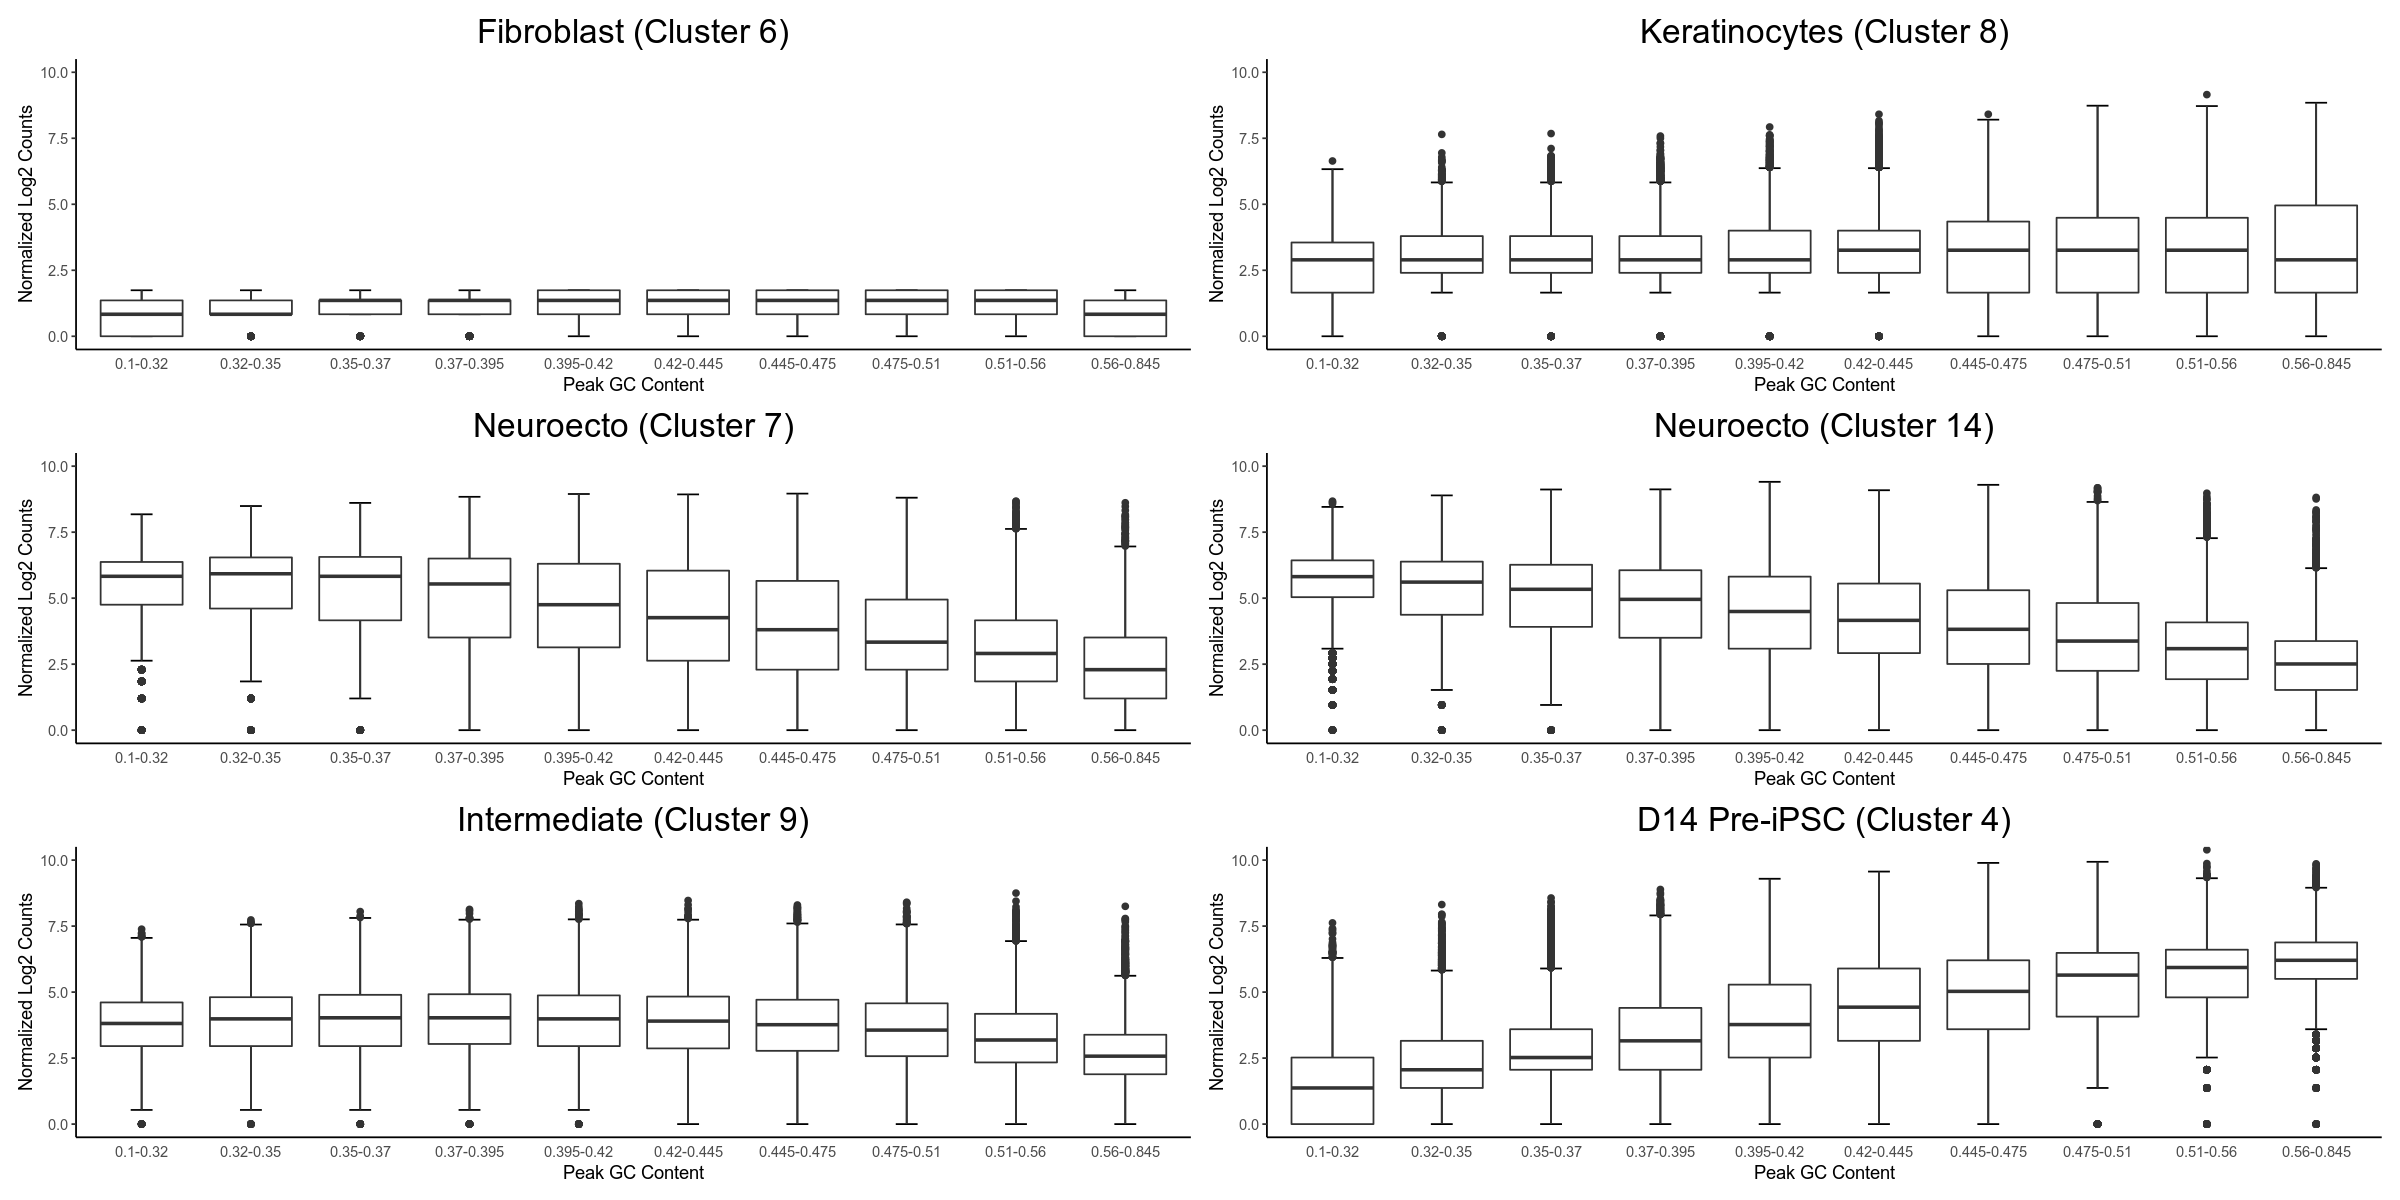

In [283]:
options(repr.plot.width = 20, repr.plot.height = 10)
(c6_violin / c7_violin / c9_violin) | ( c8_violin / c14_violin / c4_violin)

In [187]:
PREFIX = 'fibr_cluster6_lt_0.2_quantile'
BED_PATH = sprintf("beds/%s_%s_gc%d/", format(Sys.Date(), format='%Y%m%d'), PREFIX, length(levels(gc_bucket)))
# rownames(vsd_assay_to_cluster_normalized)[(which(pr_mb==CLUSTER_IDX))]
BED_PATH

[1] "beds/20200403_fibr_cluster6_lt_0.2_quantile_gc10/"

In [188]:
for (i in levels(gc_bucket)){
    BED_PATH = sprintf("beds/%s_%s_gc%d/gc_%s.bed", format(Sys.Date(), format='%Y%m%d'), PREFIX, length(levels(gc_bucket)), sub('-', '_', i))
    fileConn = file(BED_PATH)
    writeLines(rownames(cts_gc_no_prom)[peak_subset][(gc_bucket==i)], fileConn)
    close(fileConn)
}

In [189]:
ALL_PEAKS_BED_PATH = sprintf("beds/%s_%s_gc%d/all_peaks.bed", format(Sys.Date(), format='%Y%m%d'), PREFIX, length(levels(gc_bucket)))
print(ALL_PEAKS_BED_PATH)
fileConn = file(ALL_PEAKS_BED_PATH)
writeLines(rownames(cts_gc_no_prom)[peak_subset], fileConn)
close(fileConn)

[1] "beds/20200403_fibr_cluster6_lt_0.2_quantile_gc10/all_peaks.bed"


In [104]:
for (i in seq(1,18)) {
    print(sprintf("Cluster %d: %f", i, cor(cts_gc_no_prom[peak_subset, "GC"], log_norm_cts_no_prom[peak_subset,sprintf("cluster%d", i)], method='spearman')))
}

[1] "Cluster 1: 0.186160"
[1] "Cluster 2: 0.293360"
[1] "Cluster 3: 0.524606"
[1] "Cluster 4: 0.659944"
[1] "Cluster 5: 0.351639"
[1] "Cluster 6: 0.088162"
[1] "Cluster 7: -0.458952"
[1] "Cluster 8: 0.094374"
[1] "Cluster 9: -0.200354"
[1] "Cluster 10: -0.052841"
[1] "Cluster 11: 0.529692"
[1] "Cluster 12: 0.133529"
[1] "Cluster 13: 0.253715"
[1] "Cluster 14: -0.481932"
[1] "Cluster 15: -0.077350"
[1] "Cluster 16: -0.050617"
[1] "Cluster 17: 0.114315"
[1] "Cluster 18: 0.112380"


In [105]:
# global trends
for (i in seq(1,18)) {
    print(sprintf("Cluster %d: %f", i, cor(cts_gc_no_prom[, "GC"], log_norm_cts_no_prom[,sprintf("cluster%d", i)], method='spearman')))
}

[1] "Cluster 1: 0.217905"
[1] "Cluster 2: 0.305912"
[1] "Cluster 3: 0.510179"
[1] "Cluster 4: 0.609246"
[1] "Cluster 5: 0.458712"
[1] "Cluster 6: 0.217119"
[1] "Cluster 7: -0.016409"
[1] "Cluster 8: 0.408910"
[1] "Cluster 9: 0.167991"
[1] "Cluster 10: 0.240405"
[1] "Cluster 11: 0.438966"
[1] "Cluster 12: 0.312598"
[1] "Cluster 13: 0.390588"
[1] "Cluster 14: 0.025260"
[1] "Cluster 15: 0.227393"
[1] "Cluster 16: 0.175992"
[1] "Cluster 17: 0.190176"
[1] "Cluster 18: 0.204671"


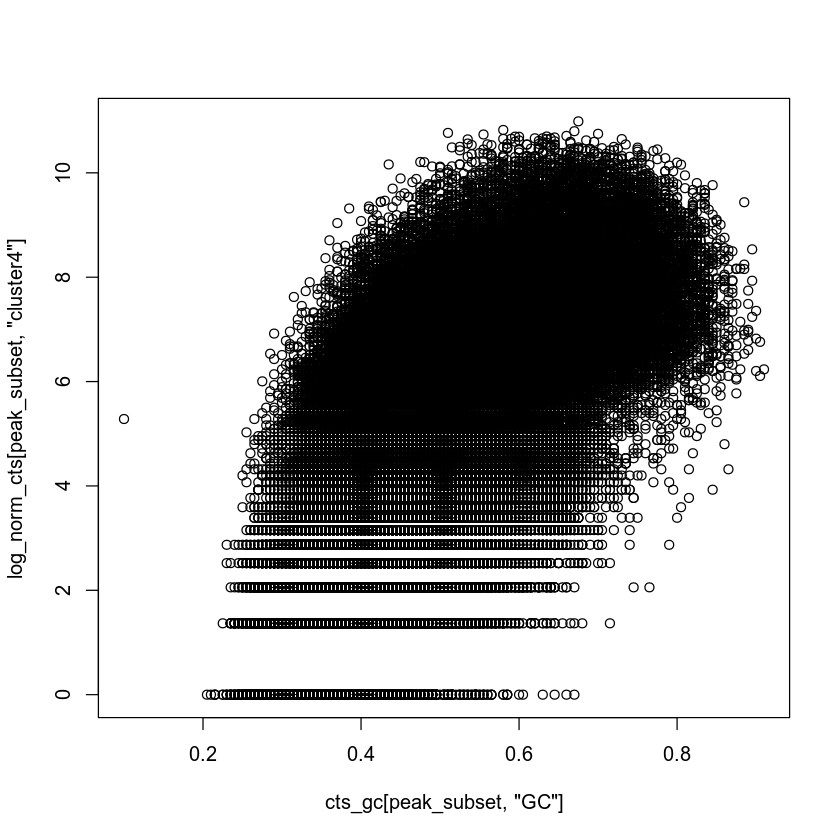

In [106]:
options(repr.plot.width = 7, repr.plot.height = 7)
plot(cts_gc[peak_subset, "GC"], log_norm_cts[peak_subset,"cluster4"])